# AirBnb Data Analysis - Cape Town, South Africa

This notebook is using data from [Inside Airbnb](http://insideairbnb.com/). The goal is to investigate the data and find out more information about the AirBnb landscape in Cape Town where I live.

Dataset access can found [ here](http://insideairbnb.com/get-the-data.html)

Some key questions / areas of investigation I have are:

## (1) Listings Dataset:
- What does the price distribution look like in Cape Town & for specific Areas?
    - What is the difference in pricing between the property types?
    - What is the difference in pricing between areas / wards ?
    - How many hosts have multiple listings and where are they?
    - What is the difference between superhosts and normal hosts pricing?

    
## (2) Reviews Dataset:
- What are the reviews like for Cape Town hosts, good or bad?
- How does demand fluctuate for AirBnb in Cape Town?
    - Is there the expected seasonality with seasons?
    - Is there higher demand with less seasonality in certain areas?
    
## (3) Price Prediction:
- As a new host, if you try to charge above market price for a listing, then renters will select more affordable alternatives which are similar. If you set price too low, you wil miss out on potential revenue as well.

- We want to use data on local listings to predict the optimal price for someone to set. 
- We will explore a specific machine learning technique called k-nearest neighbors to try do this.


# Import Datasets from S3 Bucket

In [485]:
import boto3
import pandas as pd
import numpy as np
from sagemaker import get_execution_role
import seaborn as sns
import matplotlib.pyplot as plt

role = get_execution_role()
bucket = 'dsdatasets'
listings_data_key = 'airbnb_ct/listings.csv'
reviews_data_key = 'airbnb_ct/reviews.csv'
listings_data_location = 's3://{}/{}'.format(bucket, listings_data_key)
reviews_data_location = 's3://{}/{}'.format(bucket, reviews_data_key)

listings = pd.read_csv(listings_data_location, low_memory=False)
reviews = pd.read_csv(reviews_data_location, low_memory=False)

In [486]:
# Remove columns where all values are null immediately
listings=listings.dropna(axis=1, how='all')

# (1) Listings Dataset EDA
- What does the price distribution look like in Cape Town for specific Areas?
- What is the difference in pricing between the property types?
- What is the difference in pricing between areas / wards ?
- How many hosts have multiple listings and where are they?
- What is the difference between superhosts and normal hosts pricing?

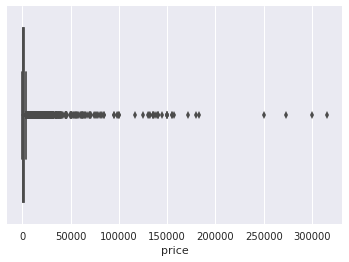

In [487]:
# The price column is not great & needs cleaning (removal of dollar sign) 
# South Africa uses Rands as currency (dataset has $)

def clean_currency(x):
    """ If the value is a string, then remove currency symbol and delimiters
    otherwise, the value is numeric and can be converted
    """
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)

listings['price'] = listings['price'].apply(clean_currency).astype('float')
sns.boxplot(x = listings['price'])

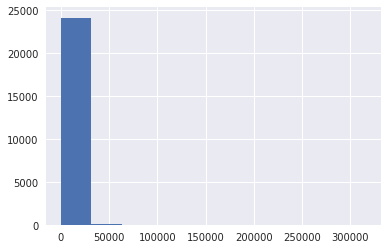

In [488]:
listings['price'].hist()

In [489]:
listings['price'].describe()

count     24318.000000
mean       2493.194218
std        7502.148453
min           0.000000
25%         685.000000
50%        1104.000000
75%        2055.000000
max      315315.000000
Name: price, dtype: float64

There seems to be a large mount of outliers in this dataset, Cape Town does have specific areas where the prices are extrememely high er night. Investigation into specific URLs of these listings also showed many test or fake accounts where the price was extremely high.

A Mean of R2493 is incredibly high for a per night cost - the average South African (and Im sure tourist) will not be happy to hear that as an average price per night.  The Std Deviation of R7502 and Max of R315,315 also indicate the skew data.

Lets remove these outliers with a strategy to make the datatset more manageable and also more realistic for the general population of listings (and people using AirBnb in Cape Town) - hopefully getting rid of the extremely expensive listings that skew the data

### Use the IQR strategy to remove outliers from the price

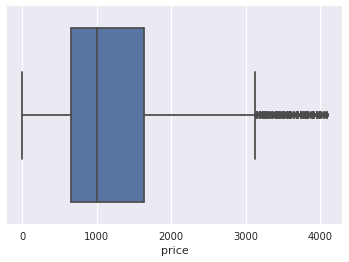

In [490]:
# Work out Interquartile range on price - using 1.5 IQR rule
Q1_price = listings['price'].quantile(0.25)
Q3_price = listings['price'].quantile(0.75)
IQR_price = Q3_price - Q1_price
lowerRange = Q1_price - (1.5 * IQR_price)
upperRange = Q3_price + (1.5 * IQR_price)

# Removing rows where price deemed as outlier given IQR

listings_iqr = listings.copy()
listings_iqr.drop(listings_iqr[(listings_iqr.price > upperRange) | (listings_iqr.price < lowerRange)].index, inplace=True)
# Take another look at the price column
sns.boxplot(x = listings_iqr['price'])

This looks significantly better, even though there are still outliers we can actually see the price information more clearly, lets check out the stats on the column again as well as plot the histogram

In [492]:
listings_iqr['price'].describe()

count    21654.000000
mean      1266.477741
std        867.972734
min          0.000000
25%        647.000000
50%       1009.000000
75%       1637.000000
max       4092.000000
Name: price, dtype: float64

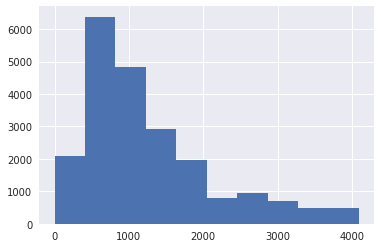

In [493]:
listings_iqr['price'].hist()

The left skewed distribution of listing prices in Cape Town ranges up to a maximum of arounf R4000, with a mean of around R1266

This seems more reasonable to me than the R2493 mean price seen earlier where the mean is now R1266 and the Max is at R4092

### Lets consider looking into the actual room types and property types now before coming back to this price distribution....

- What is the difference in pricing between the property types?
- What is the difference in pricing between areas / wards ?

In [494]:
print('We have', listings_iqr.id.nunique(), 'listings in the listing data.')

We have 21654 listings in the listing data.


In [495]:
# What is the breakdown of the listings by room type / property types ?
listings_iqr['room_type'].value_counts() / (listings_iqr.shape[0] - sum(listings_iqr['room_type'].isnull()))

Entire home/apt    0.738663
Private room       0.237046
Hotel room         0.017826
Shared room        0.006465
Name: room_type, dtype: float64

Almost 74% of the listings in Cape Town are for Entire Homes / Apartments - I guess this isnt too surprising

Lets see if there is a price difference between these room types

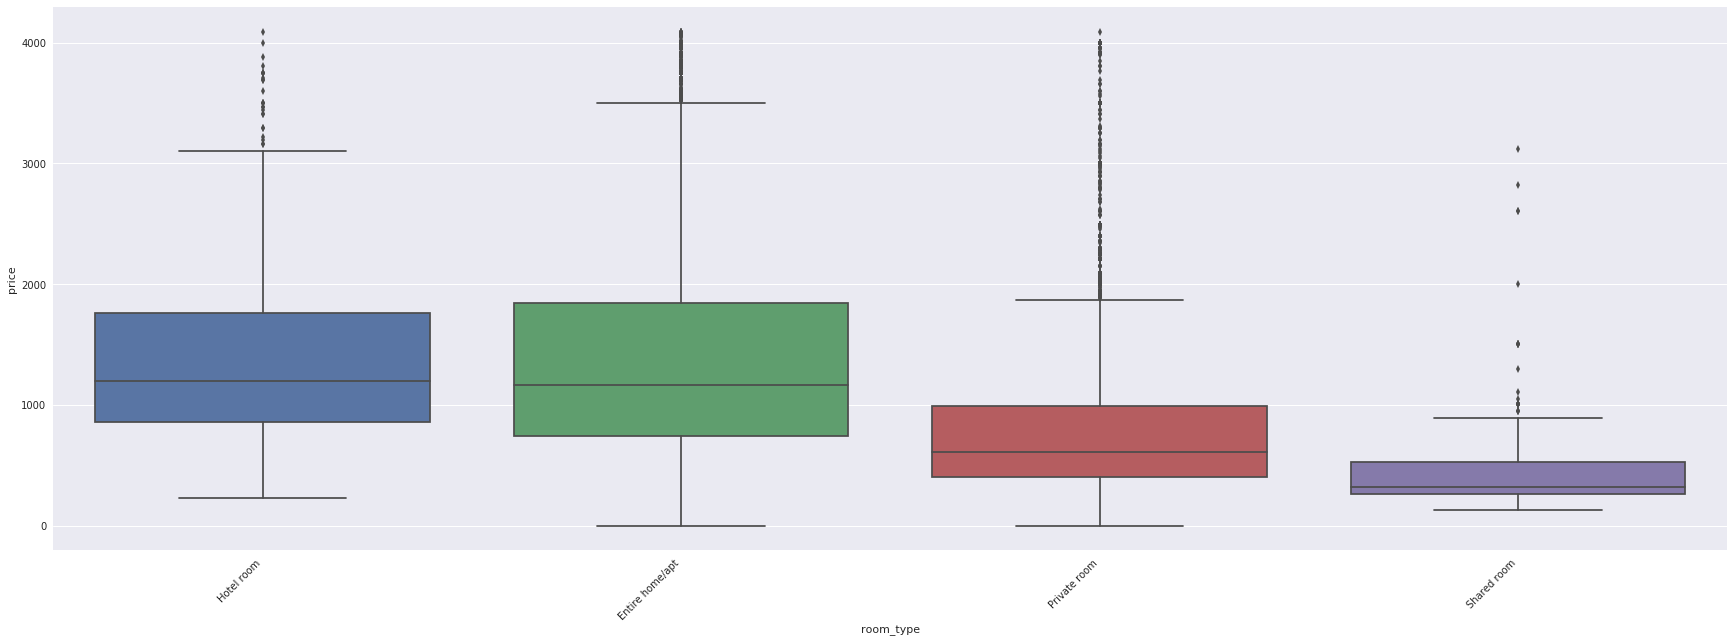

In [496]:
# Room Type vs Price
plt.figure(figsize=(30,10))
sort_price = listings_iqr\
                    .groupby('room_type')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='room_type', data=listings_iqr, order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

The median price points show us that Hotel Rooms are the most expensive followed by the Entire Home / Apartment room type - but not by much! 

What about when we look at property types?

In [498]:
listings_iqr.groupby(by='property_type').count()[['id']].sort_values(by='id', ascending=False).head(10)

,id
property_type,
Apartment,9384
House,5796
Guest suite,1501
Guesthouse,977
Bed and breakfast,607
Condominium,576
Townhouse,541
Cottage,443
Serviced apartment,413


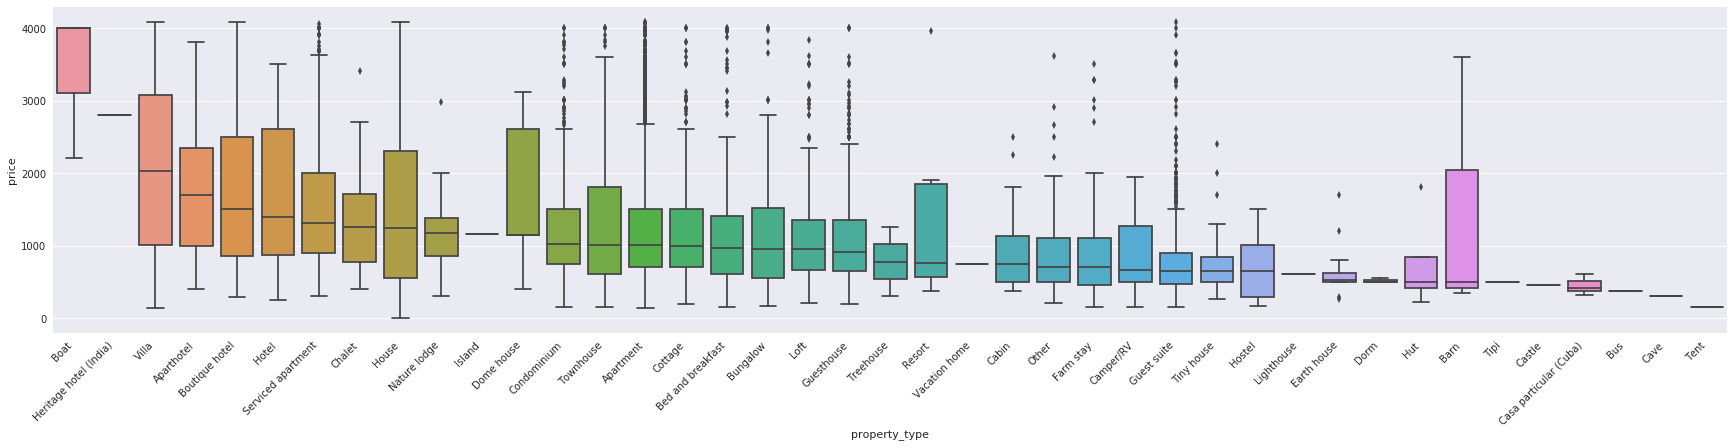

In [499]:
# Property Type by Price
plt.figure(figsize=(30,6))
sort_price = listings_iqr\
                    .groupby('property_type')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='property_type', data=listings_iqr, order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

### What is the difference in pricing between the property types?

Apartments & Houses make up the bulk which is no surprise, when looking at the box plots ranking price we see the Boat property type with the highest median price (need to check that out!)

Tent, Cave & Bus have the lowest median price (Cave? - also need to check that out!)

Apartment shows up in 15th Place with a median price around R1000 while House is in 9th with a median price around R1300

Lets focus on the Neighbourhood variable to see what comes up...

In [501]:
# Most listings by ward (neighbourhood)
listings_iqr.groupby(by='neighbourhood_cleansed').count()[['id']].sort_values(by='id', ascending=False).head(10)

,id
neighbourhood_cleansed,
Ward 115,4027
Ward 54,2209
Ward 77,1748
Ward 23,1239
Ward 64,1101
Ward 74,913
Ward 61,856
Ward 57,752
Ward 59,634


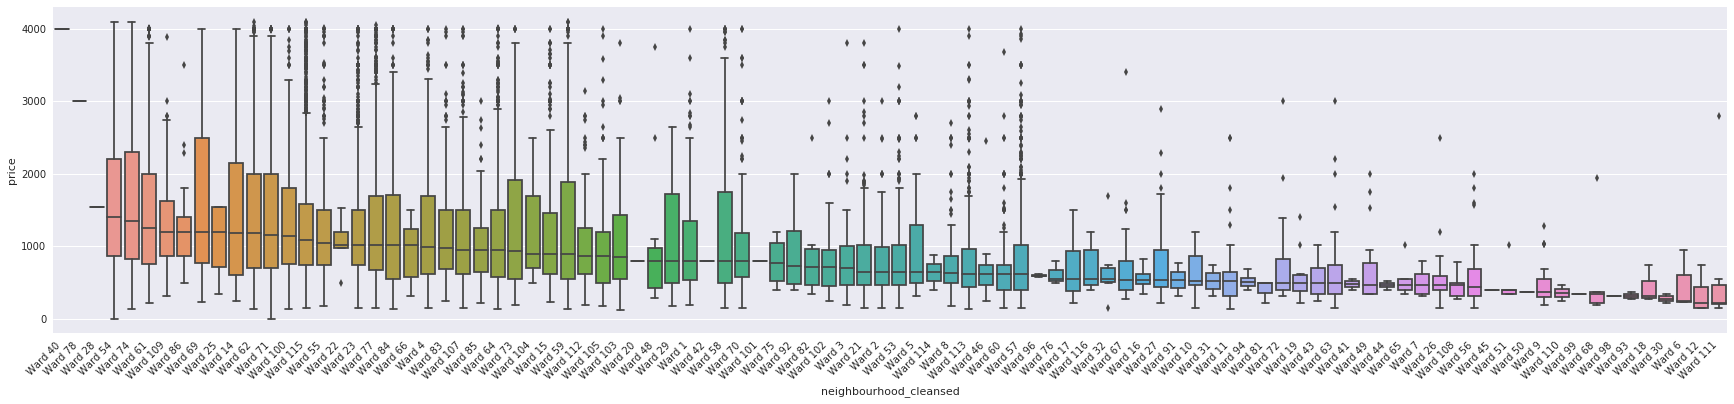

In [502]:
# Neighbourhood vs Price
plt.figure(figsize=(30,6))
sort_price = listings_iqr.groupby('neighbourhood_cleansed')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='neighbourhood_cleansed', data=listings_iqr, 
            order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

### What is the difference in pricing between areas / wards ?

Ward 115, 54 & 77 have the top 3 most amount of listings in the city, price plots show how they are costed.

The Ward information for Cape Town can be found [ here](https://www.capetown.gov.za/Family%20and%20home/Meet-the-City/City-Council/find-your-councillor-ward-or-subcouncil/show-wards?FirstWardSequenceNo=100&LastWardSequenceNo=)

#### Ward 115 includes areas such as:

- Cape Town City Centre 
- Foreshore 
- Gardens 
- Green Point 
- Mouille Point 
- Paarden Eiland 
- Salt River 
- Three Anchor Bay 
- Woodstock 
- Zonnebloem

-- The Ward is 15th in terms of Median pricing ranking, just above R1000

#### Ward 54 includes areas such as:

- Bantry Bay 
- Camps Bay 
- Bakoven 
- Clifton 
- Fresnaye 
- Oudekraal 
- Robben Island 
- Sea Point 
- Signal Hill 
- Three Anchor Bay

-- The Ward is 4th in terms of Median pricing ranking, just above R1500

#### Ward 77 includes areas such as:

- Bo-Kaap (Bo Kaap, Bokaap) 
- Gardens (West of New Church Street)
- Oranjezicht
- Schotschekloof 
- Signal Hill 
- Tamboerskloof 
- Vredehoek

-- The Ward is 19th in terms of Median pricing ranking, just below R1000

These ares are very popular as they are close to tourist attractions and are generally popular areas in the City, so it makes perfect sense that the volume of listings sit here.


### What does the price distribution look like in Cape Town for specific Areas?

I wanted to come back to this after we find out the main areas in the city.
Lets focus on the main areas (wards) found above and plot them on individual histograms

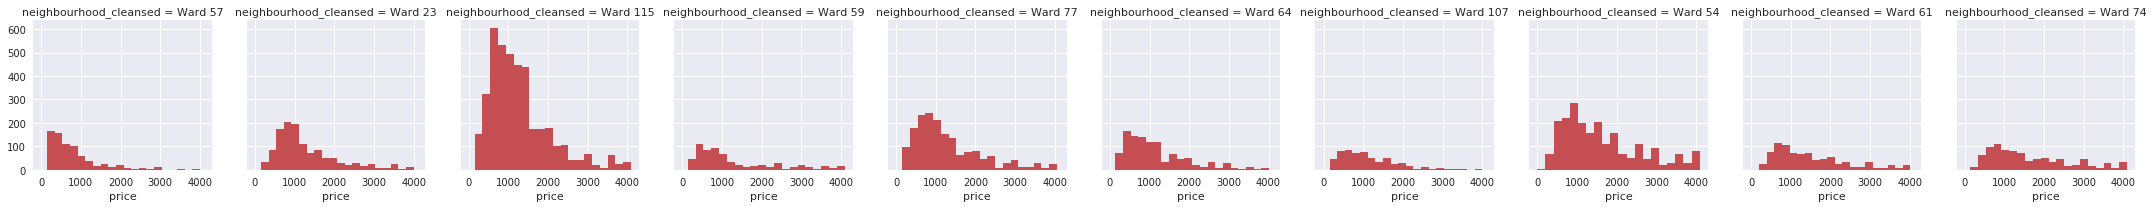

In [505]:
# Make a dataframe with the top 10 Wards
wards = ['Ward 115','Ward 54', 'Ward 77', 'Ward 23', 'Ward 64', 'Ward 74', 'Ward 61', 'Ward 57','Ward 59', 'Ward 107']
top_wards= listings_iqr[listings_iqr.neighbourhood_cleansed.isin(wards)]
# Build histograms for each Ward
g = sns.FacetGrid(data = top_wards, col = 'neighbourhood_cleansed', col_wrap = 10)
g.map(plt.hist, 'price', bins = 20, color = 'r')

## What is the difference between superhosts and normal hosts pricing?

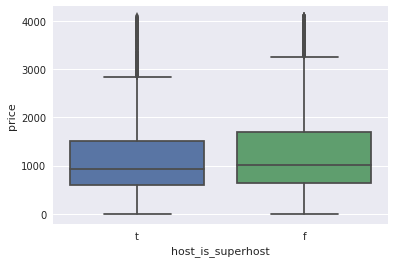

In [506]:
# Host vs Price - IQR Listings
sns.boxplot(y='price', x='host_is_superhost', data=listings_iqr)
plt.show();

 Superhosts actually have a slightly lower median price, there seems to be no real difference

## How many hosts have multiple listings and where are they?

In [507]:
hl = listings_iqr.groupby(by='id').count()[['host_total_listings_count']].sort_values(by='id', ascending=False)
hl.head()

,host_total_listings_count
id,
43273177,1
43273175,1
43273174,1
43273173,1
43273172,1


In [508]:
multiple_listings = listings_iqr.groupby(by='host_id').count()[['id']].sort_values(by='id', ascending=False)
multiple_listings = multiple_listings.loc[multiple_listings['id'] > 1]
multiple_listings['host_id'] = multiple_listings.index
multiple_listings.head()

,id,host_id
host_id,,
130248430,392,130248430
29426065,98,29426065
185308070,85,185308070
3961453,83,3961453
3886732,74,3886732


There are 2929 hosts who have more than one listing

In [509]:
multiple_listings.id.sum()

10824

A total of 10,824 properties form part of the 'multi hosts' portfolio

In [510]:
# Make a new dataframe with these multihosts listings
listings_multi = listings_iqr[listings_iqr.set_index(['host_id']).index.isin(multiple_listings.set_index(['host_id']).index)]
listings_multi.shape

(10824, 100)

In [511]:
# What is the breakdown of the listings by room type / property types ?
listings_multi['room_type'].value_counts() / (listings_multi.shape[0] - sum(listings_multi['room_type'].isnull()))

Entire home/apt    0.662694
Private room       0.294254
Hotel room         0.034368
Shared room        0.008684
Name: room_type, dtype: float64

In [512]:
listings_multi.groupby(by='property_type').count()[['id']].sort_values(by='id', ascending=False).head(10)

,id
property_type,
Apartment,4651
House,2285
Guest suite,709
Guesthouse,695
Bed and breakfast,536
Serviced apartment,355
Condominium,302
Townhouse,227
Villa,203


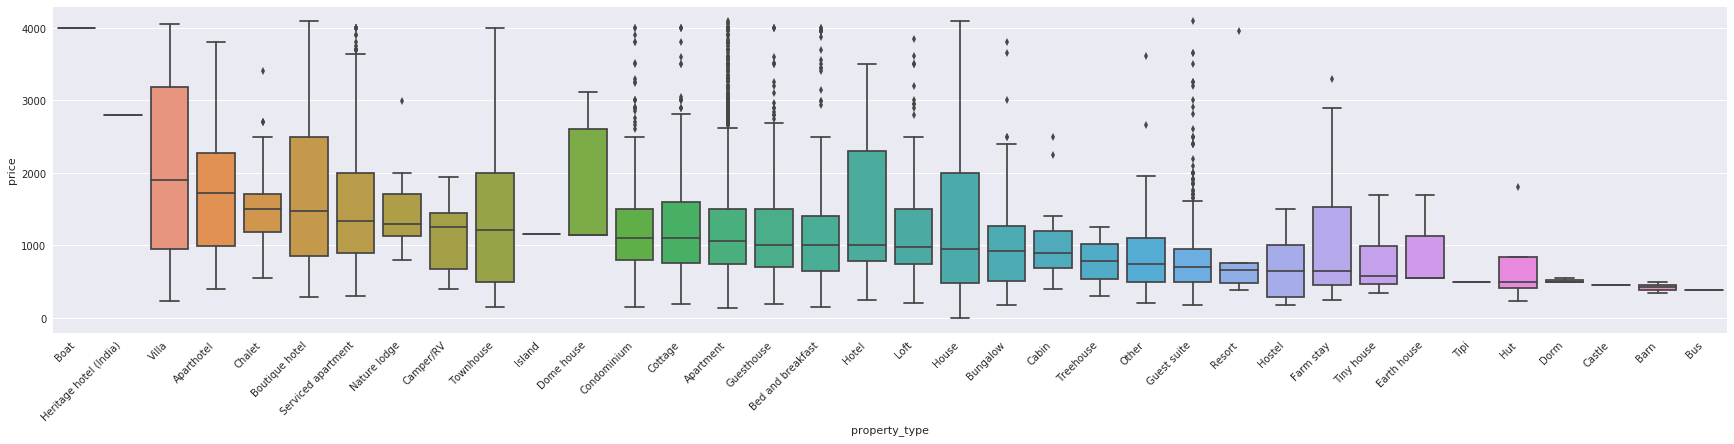

In [513]:
# Property Type by Price
plt.figure(figsize=(30,6))
sort_price = listings_multi\
                    .groupby('property_type')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='property_type', data=listings_multi, order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

In [514]:
# Most listings by ward (neighbourhood)
listings_multi.groupby(by='neighbourhood_cleansed').count()[['id']].sort_values(by='id', ascending=False).head(10)

,id
neighbourhood_cleansed,
Ward 115,2422
Ward 54,1246
Ward 77,770
Ward 23,624
Ward 64,484
Ward 74,442
Ward 61,422
Ward 55,360
Ward 57,355


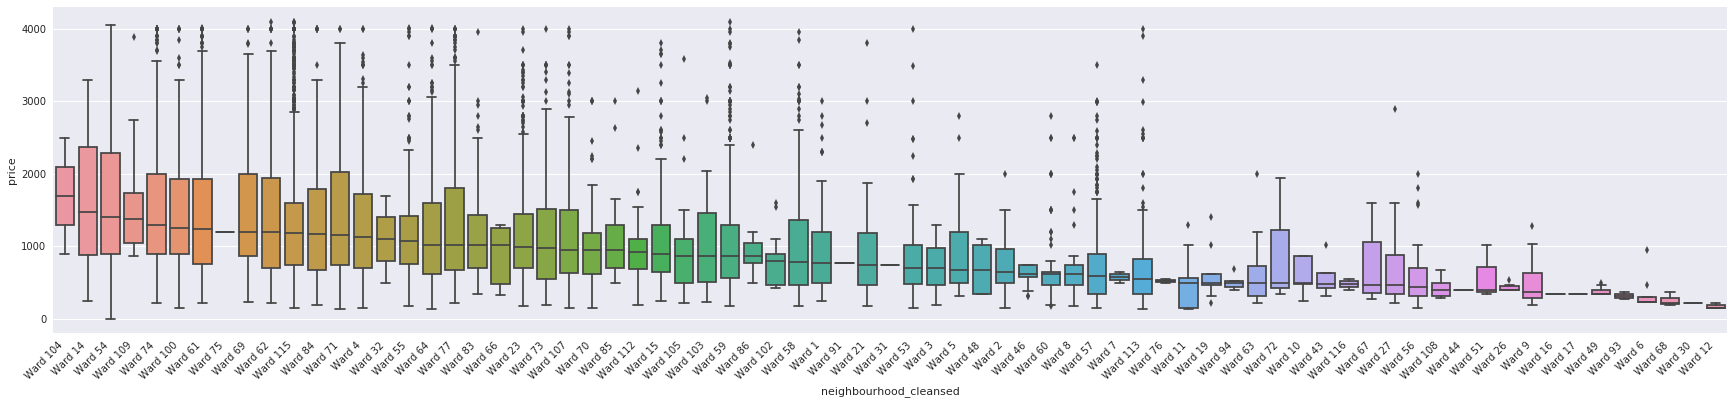

In [515]:
# Neighbourhood vs Price
plt.figure(figsize=(30,6))
sort_price = listings_multi.groupby('neighbourhood_cleansed')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='neighbourhood_cleansed', data=listings_multi, 
            order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

In [516]:
listings_multi['price'].describe()

count    10824.000000
mean      1263.422857
std        845.294673
min          0.000000
25%        647.000000
50%       1009.000000
75%       1599.000000
max       4092.000000
Name: price, dtype: float64

### Multi Hosts Summary of findings:

There are 2929 hosts with multiple listings, we cant assume these are all single individuals with the increase of companies who take on the hosting role on behalf of owners, so there may be specific companies with the same host id.  This is highly probable with the one host having 392 listings

The 10824 listings linked to these 'multi-hosts' make up 49,99% (50%) of all the listings in Cape Town.

66% of those listings are for Entire Homes / Apartments and 41% of them are found in the top 3 Wards (neighbourhoods) we located earlier.

# (2) Reviews Dataset:

- What are the reviews like for Cape Town hosts, good or bad?
- How does demand fluctuate for AirBnb in Cape Town?
    - Is there the expected seasonality with seasons?
    - Is there higher demand with less seasonality in certain areas?

## What are the reviews like for Cape Town hosts, good or bad?

We will still use the Listings data for this check as the Reviews dataset link sto the listing id

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


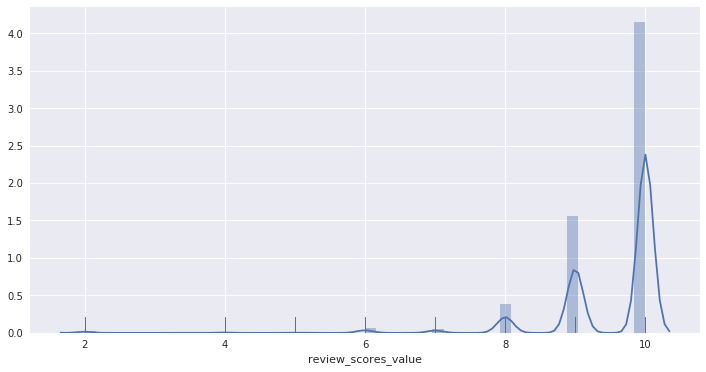

In [517]:
# review score rating
plt.figure(figsize=(12,6))
sns.distplot(listings_iqr.review_scores_value.dropna(), rug=True)
sns.despine()
plt.show();

In [518]:
listings_iqr.review_scores_value.describe()

count    15572.000000
mean         9.511238
std          0.929160
min          2.000000
25%          9.000000
50%         10.000000
75%         10.000000
max         10.000000
Name: review_scores_value, dtype: float64

It seems that the reviews given are high, there have been a few low ones but with a mean of 9,5 its fair to say the reviews are good for Cape Town listings

## How does demand fluctuate for AirBnb in Cape Town?

Now we use the Reviews data, some notes:

In this section, we will analyse the demand for Airbnb listings in Cape Town. We will look at demand over the years and across months of the year to understand seasonlity.

To study the demand, since we do not have data on the bookings made over the past year, we will use ‘number of reviews’ variable as the indicator for demand. As per Airbnb, about 50% of guests review the hosts/listings, hence studying the number of review will give us a good estimation of the demand.


In [519]:
# Demand & Price analysis
# Look at demand over the years since inception
# no data on bookings, so we use the number of reviews as the indicator for demand
# As per AirBnb, about 50% of guests review the hosts

# Change the date to datetime
reviews['date'] = pd.to_datetime(reviews['date'])
# Now that the Date column is the correct data type, let’s set it as the DataFrame’s index
reviews = reviews.set_index('date')

# Add columns with year, month, and weekday name
reviews['Year'] = reviews.index.year
reviews['Month'] = reviews.index.month
reviews['Weekday Name'] = reviews.index.weekday_name
# Display a random sampling of 5 rows
reviews.sample(5, random_state=0)


,listing_id,id,reviewer_id,reviewer_name,comments,Year,Month,Weekday Name
date,,,,,,,,
2018-12-18,14330604,359871918,56803640,Jannik,Had a great stay in Cape Town. Very central lo...,2018,12,Tuesday
2020-04-10,3338147,622122064,269779525,Lukas,Great value for money!,2020,4,Friday
2017-03-20,17427691,138502145,118830863,Jenna Leigh,"I loved my stay! The apartment is spacious, sp...",2017,3,Monday
2019-02-25,31364607,416856919,126168972,Tiffany,Views made me not ever want to leave the apart...,2019,2,Monday
2020-03-16,5502834,618978720,49197297,Anthony,Great week in Cape Town. Everything was perfec...,2020,3,Monday


Text(0.5, 1.0, 'Number of Reviews across Years')

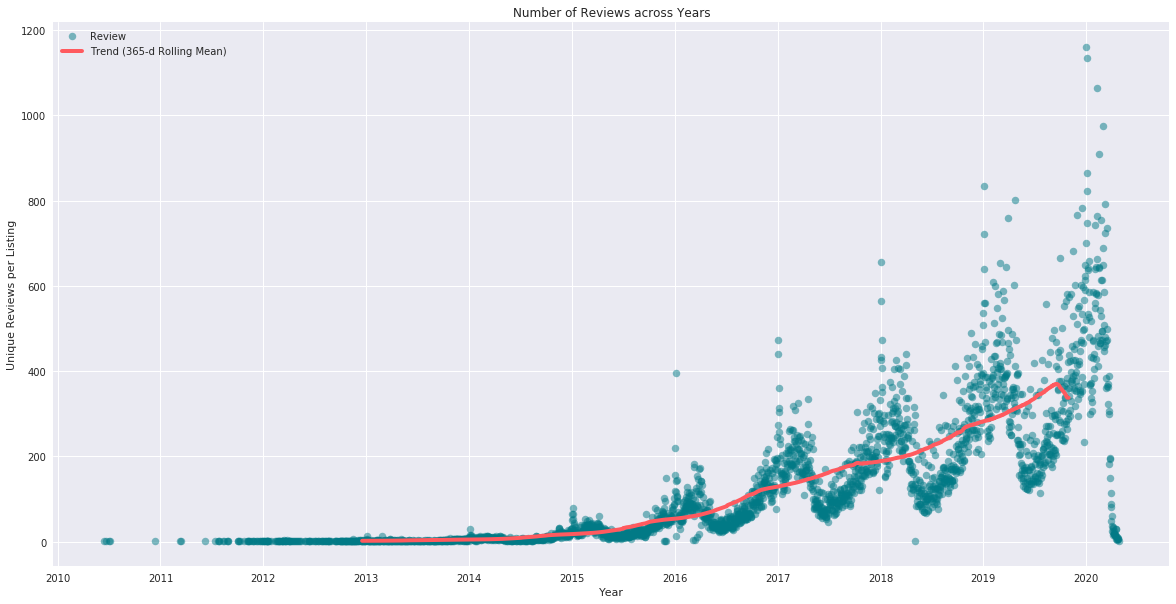

In [520]:
# Build a demand graph with a trendline (rolling 365 days mean)
# Multiple listings means we must group by a date first
counts = reviews.groupby([reviews.index.date]).count()
mean_365d = counts['listing_id'].rolling(window=365,center =True, min_periods=360).mean()
# Plot Figure
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(counts['listing_id'], marker='.', markersize=15, color='#017A86',alpha=0.5, linestyle='None', label='Review')
ax.plot(mean_365d, linewidth=4, color='#FF5A5F',label = 'Trend (365-d Rolling Mean)')
# Set legend and labels
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Unique Reviews per Listing')
ax.set_title('Number of Reviews across Years')

The number of listings recieving reviews has increased over the years meaning the demand has increased dramatically as well.

There is also clearly seasonality in the demand where every year there are highs and lows, meaning certain months are busier than others.

Lets look at monthly demands ....

Text(0.5, 1.0, 'Number of Reviews across Weeks of 2019')

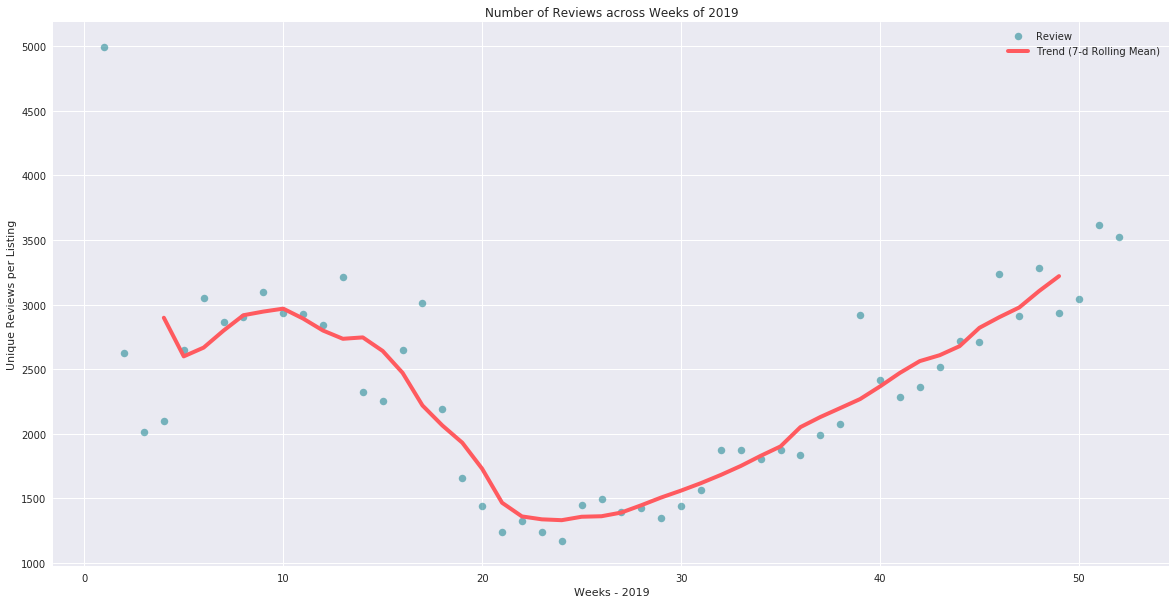

In [521]:
# Select specific year to look at, and lets focus on the weeks of the year
#  Trendline over 7 days rolling average
yeardf = reviews.loc['2019']
year_month_counts = yeardf.groupby([yeardf.index.week]).count()
year_month_mean_7d = year_month_counts['listing_id'].rolling(7,center =True).mean()


fig, ax = plt.subplots(figsize=(20,10))
ax.plot(year_month_counts['listing_id'], marker='.', markersize=15, color='#017A86',alpha=0.5, linestyle='None', label='Review')
ax.plot(year_month_mean_7d, linewidth=4, color='#FF5A5F',label = 'Trend (7-d Rolling Mean)')
# Set legend and labels
ax.legend()
ax.set_xlabel('Weeks - 2019')
ax.set_ylabel('Unique Reviews per Listing')
ax.set_title('Number of Reviews across Weeks of 2019')

Time to look at specific areas to see if there is seasonality - lets look at the most highly poplated areas (wards) when it comes to AirBnb property

We know that Ward 115 has the most listings (4027)

In [522]:
topward = listings_iqr.loc[listings_iqr['neighbourhood_cleansed'] == 'Ward 115']
topward.shape

(4027, 100)

In [523]:
# We need to get the filter the reviews data frame by the listing_id in this dataframe now
topward_reviews = reviews[reviews.set_index(['listing_id']).index.isin(topward.set_index(['id']).index)]
topward_reviews.shape

(110881, 8)

### Now lets run these Ward 115 reviews through the above analysis to check for seasonality...

Text(0.5, 1.0, 'Number of Reviews across Weeks of 2019')

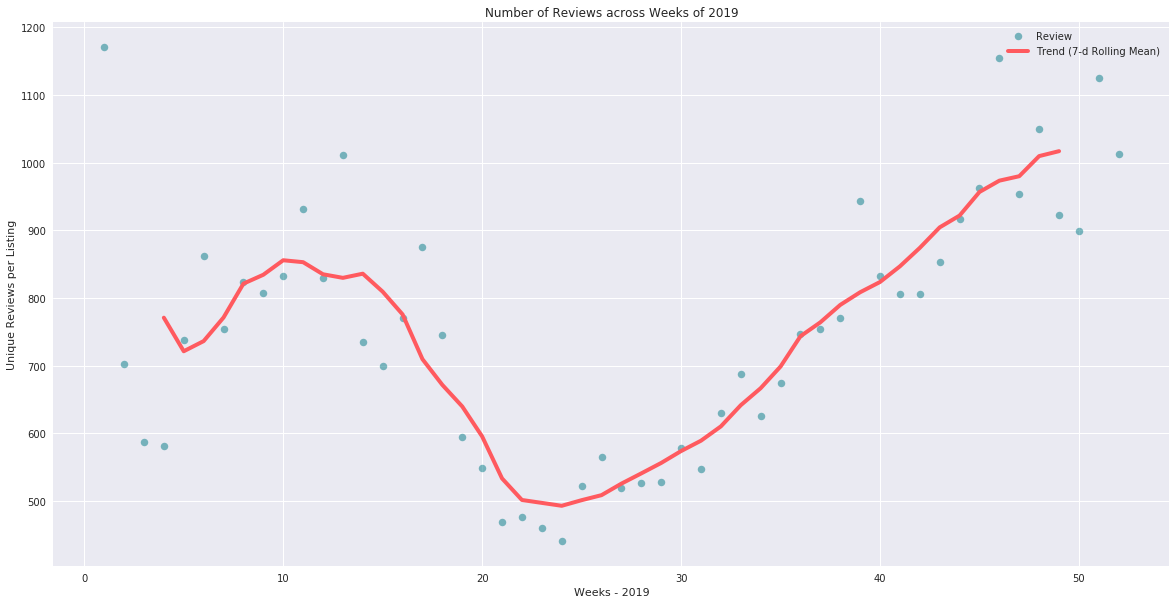

In [524]:
yeardf = topward_reviews.loc['2019']
year_month_counts = yeardf.groupby([yeardf.index.week]).count()
year_month_mean_7d = year_month_counts['listing_id'].rolling(7,center =True).mean()


fig, ax = plt.subplots(figsize=(20,10))
ax.plot(year_month_counts['listing_id'], marker='.', markersize=15, color='#017A86',alpha=0.5, linestyle='None', label='Review')
ax.plot(year_month_mean_7d, linewidth=4, color='#FF5A5F',label = 'Trend (7-d Rolling Mean)')
# Set legend and labels
ax.legend()
ax.set_xlabel('Weeks - 2019')
ax.set_ylabel('Unique Reviews per Listing')
ax.set_title('Number of Reviews across Weeks of 2019')

# (3) Price Prediction:
- As a new host, if you try to charge above market price for a listing, then renters will select more affordable alternatives which are similar. If you set price too low, you wil miss out on potential revenue as well.

- We want to use data on local listings to predict the optimal price for someone to set. 
- We will explore a specific machine learning technique called k-nearest neighbors to try do this.

In [525]:
# Current shape of the listings dataframe (after cleaning up outliers)
o, f = listings_iqr.shape
print('Number of observations:',o)
print('Number of features:',f)

Number of observations: 21654
Number of features: 100


## (3) | 1. Data Cleaning

In [526]:
# Columns we want to keep that relate to the listings price
columns = ['host_response_rate','host_acceptance_rate', 'host_listings_count', 'latitude',
           'longitude', 'city', 'zipcode', 'state', 'accommodates', 'room_type', 'bedrooms',
          'bathrooms', 'beds', 'price', 'cleaning_fee', 'security_deposit', 'minimum_nights',
          'maximum_nights', 'number_of_reviews']

listings_km = listings_iqr[columns]
listings_km.shape

(21654, 19)

In [527]:
# How many features are there of each data type?
dtype={}
for data_type in listings_km.dtypes:
    if data_type not in dtype:
        dtype[data_type] = 1
    else:
        dtype[data_type] += 1
    
dtype

{dtype('O'): 8, dtype('float64'): 7, dtype('int64'): 4}

In [528]:
listings_km.isnull().sum()

host_response_rate      6948
host_acceptance_rate    4474
host_listings_count        3
latitude                   0
longitude                  0
city                      51
zipcode                  590
state                    370
accommodates               0
room_type                  0
bedrooms                  29
bathrooms                 13
beds                     107
price                      0
cleaning_fee            6188
security_deposit        7819
minimum_nights             0
maximum_nights             0
number_of_reviews          0
dtype: int64

In [529]:
# While we could convert the host_response_rate and host_acceptance_rate columns 
# to be numerical (right now they're object data types and contain the % sign), 
# these columns describe the host and not the living space itself. 
# Since a host could have many living spaces and we don't have enough 
# information to uniquely group living spaces to the hosts themselves, 
# let's avoid using any columns that don't directly describe the living 
# space or the listing itself:

#Lets remove these
drop_columns = ['host_response_rate', 'host_acceptance_rate', 'host_listings_count']
listings_km = listings_km.drop(drop_columns, axis=1)
print(listings_km.isnull().sum())

latitude                0
longitude               0
city                   51
zipcode               590
state                 370
accommodates            0
room_type               0
bedrooms               29
bathrooms              13
beds                  107
price                   0
cleaning_fee         6188
security_deposit     7819
minimum_nights          0
maximum_nights          0
number_of_reviews       0
dtype: int64


In [530]:
# The following columns contain non-numerical values:
# room_type
# city:
# state

# while these columns contain numerical but non-ordinal values:
# latitude
# longitude
# zipcode

#Lets also remove these
drop_columns = ['room_type', 'city', 'state', 'latitude', 'longitude', 'zipcode']
listings_km = listings_km.drop(drop_columns, axis=1)
print(listings_km.isnull().sum())

accommodates            0
bedrooms               29
bathrooms              13
beds                  107
price                   0
cleaning_fee         6188
security_deposit     7819
minimum_nights          0
maximum_nights          0
number_of_reviews       0
dtype: int64


In [531]:
# Of the remaining columns, 3 columns have a few missing values:
# bedrooms
# bathrooms
# beds
# We will replace these with the mean values of each column

# There are also 2 columns that have a large number of missing values:
# cleaning_fee - 28.5% of the rows
# security_deposit - 36.1% of the rows
# We can't just remove the rows containing missing values for these 2 columns 
# because we'd miss out on the majority of the observations in the dataset. 
# Instead, let's remove these 2 columns entirely from consideration.

fill_mean = lambda col: col.fillna(col.mean())

drop_columns = ['cleaning_fee', 'security_deposit']
listings_km = listings_km.drop(drop_columns, axis=1)

listings_km = listings_km.apply(fill_mean, axis=0)
print(listings_km.isnull().sum())


accommodates         0
bedrooms             0
bathrooms            0
beds                 0
price                0
minimum_nights       0
maximum_nights       0
number_of_reviews    0
dtype: int64


## (3) | 2. Normalize the dataframe

In [466]:
normalized_listings_km = (listings_km - listings_km.mean()) / (listings_km.std())
normalized_listings_km['price'] = listings_km['price']

## (3) | 3. Feature Selection & Hyperparameter Optimization

- select relevant features to use for predicting the target column.
- use grid search to find the optimal hyperparameter value for the selected features.
- evaluate the model's accuracy and repeat the process.

### Univariate Analysis of the features... which ones perform best

In [532]:
# Build a function that goes over each feature and tests the k value up to 25
# Split the trainign and test dataset (randomly) 50/50 split
# Train a KMEans model on the datasets and make predicitons for price and the test data
# Calculate the MSE and RMSE for the predicitons on price
# Show the results in a dictionary where the RMSE is hown for each k value
#  Expecting a list of the features with k value and RMSE

def knn_train_test(train_col, target_col, df):
    np.random.seed(7)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [1,3,5,7,9,11,13,15,17,19,21,22,23,25]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[[train_col]], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[[train_col]])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

# For each column (minus `price`), train a model, return RMSE value
# and add to the dictionary `rmse_results`.
train_cols = normalized_listings_km.columns.drop('price')
for col in train_cols:
    rmse_val = knn_train_test(col, 'price', normalized_listings_km)
    k_rmse_results[col] = rmse_val

k_rmse_results

{'accommodates': {1: 929.1525059587657,
  3: 744.2894990176587,
  5: 741.4604867271531,
  7: 734.0475045800604,
  9: 739.2165048747804,
  11: 743.1350692739113,
  13: 737.1925426760577,
  15: 728.2143436582508,
  17: 736.38293271914,
  19: 733.193212115379,
  21: 731.7147955044823,
  22: 728.2176402457862,
  23: 728.2406401802778,
  25: 728.1009887087878},
 'bedrooms': {1: 928.0552855323468,
  3: 810.3122017407196,
  5: 748.9946252777314,
  7: 730.864200655718,
  9: 720.6799183735852,
  11: 729.3383962753421,
  13: 721.3674025326922,
  15: 723.6351116542921,
  17: 715.9055659845717,
  19: 716.7131041539166,
  21: 715.8094237296622,
  22: 716.7384118709967,
  23: 717.9608210226672,
  25: 717.197480121146},
 'bathrooms': {1: 2110.375324301555,
  3: 1224.3399617480563,
  5: 923.6479362523152,
  7: 887.1677386407703,
  9: 825.054840603158,
  11: 765.388867877636,
  13: 742.248322653772,
  15: 729.2694100124833,
  17: 727.1732750284866,
  19: 729.1724119289318,
  21: 725.3250610452836,
  22

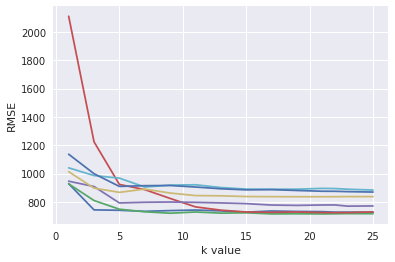

In [533]:
# Plot the results from above to view the RMSE over the k values

import matplotlib.pyplot as plt
%matplotlib inline

for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')

We can see from the plot above that around k = 5 the RMSE flattens out for each feature...
Lets rank our features from best to worst performing (RMSE)

In [534]:
# Compute average RMSE across different `k` values for each feature.
#  Rank the features from best RMSE to identify best perfomers
feature_avg_rmse = {}
for k,v in k_rmse_results.items():
    avg_rmse = np.mean(list(v.values()))
    feature_avg_rmse[k] = avg_rmse
series_avg_rmse = pd.Series(feature_avg_rmse)
sorted_series_avg_rmse = series_avg_rmse.sort_values()
print(sorted_series_avg_rmse)

sorted_features = sorted_series_avg_rmse.index

bedrooms             743.826568
accommodates         748.754190
beds                 805.730509
minimum_nights       863.247396
bathrooms            897.751255
number_of_reviews    916.008960
maximum_nights       919.900166
dtype: float64


The best performing feature is the bedroom column followed by the accommodates column

### Multivariate Analysis of the features...

We now have our best performing features ranked, lets update our function to use these and then see what the RMSE is when we add more features to the model

In [535]:
# Update the function to accept more than once column (list)
# Set k = 5 for now based on our plot above
# Use the best 2 features from the previous step to train and test a multivariate k-nearest neighbors model using the default k value.
# Use the best 3 features from the previous step to train and test a multivariate k-nearest neighbors model using the default k value.
#  Keep doing this for all 7 features
#  Display the RMSE

def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [5]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

for nr_best_feats in range(2,8):
    k_rmse_results['{} best features'.format(nr_best_feats)] = knn_train_test(
        sorted_features[:nr_best_feats],
        'price',
        normalized_listings_km
    )

k_rmse_results

{'2 best features': {5: 754.4048051749926},
 '3 best features': {5: 771.5353751719847},
 '4 best features': {5: 752.0763425642342},
 '5 best features': {5: 708.6930153191378},
 '6 best features': {5: 730.8031761659662},
 '7 best features': {5: 721.6373496854701}}

### Hyperparameter Tuning

- The above shows our best RMSE is with 5 features (R708)
- This is not the only lever to play with for k means - we can tune the k value so lets update our function to now go over the models again, but instead run over different k values from 1 to 25
- Show the RMSE results for each model

In [536]:
def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [i for i in range(1, 25)]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

for nr_best_feats in range(2,6):
    k_rmse_results['{} best features'.format(nr_best_feats)] = knn_train_test(
        sorted_features[:nr_best_feats],
        'price',
        normalized_listings_km
    )

k_rmse_results

{'2 best features': {1: 940.8340624545439,
  2: 778.5849936510451,
  3: 761.6350968412171,
  4: 740.5968974030737,
  5: 754.4048051749926,
  6: 711.0195082540874,
  7: 711.8685567873924,
  8: 710.2356306599835,
  9: 709.913839700871,
  10: 715.6973771232729,
  11: 720.6952850702747,
  12: 714.0417823555736,
  13: 711.731275022127,
  14: 706.0691176580483,
  15: 703.2271850607617,
  16: 697.8700445733077,
  17: 696.5600651438615,
  18: 696.9400602551469,
  19: 695.5407485494356,
  20: 692.9895521446471,
  21: 690.7652580889014,
  22: 691.6020262522238,
  23: 692.7680267622687,
  24: 693.751578814135},
 '3 best features': {1: 986.166208085392,
  2: 837.0767635261816,
  3: 775.7999345965139,
  4: 836.3781195866459,
  5: 771.5353751719847,
  6: 740.115120143157,
  7: 730.9971751989818,
  8: 717.2008731900431,
  9: 714.1520738500058,
  10: 708.3591646606101,
  11: 717.4797841043201,
  12: 713.1418243048091,
  13: 709.3000203467631,
  14: 706.6836521411207,
  15: 704.776094325498,
  16: 700.

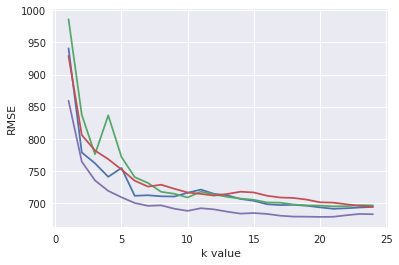

In [537]:
# Lets plot out these results to view eahc model over the k values and RMSE
for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')

The model with the 5 best features performs best at k = 20 (R678,10)

A reminder of the 5 best features (and RMSE) from above:

- bedrooms             743.826568
- accommodates         748.754190
- beds                 805.730509
- minimum_nights       863.247396
- bathrooms            897.751255

## (3) | 4. K-Fold Cross Validation

To build a better k-nearest neighbors model, we can change the features it uses or tweak the number of neighbors (a hyperparameter). To accurately understand a model's performance, we can perform k-fold cross validation and select the proper number of folds.

In [538]:
from sklearn.model_selection import cross_val_score, KFold
# use the understanding from above with 5 features (best performing model)
X = normalized_listings_km[['bedrooms', 'accommodates', 'beds', 'minimum_nights', 'bathrooms']]
y = normalized_listings_km["price"]
#  Setup the K Fold Cross Validation (use 10 for now)
kf = KFold(10, shuffle=True, random_state=1)
model = KNeighborsRegressor()
mses = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf)
rmses = np.sqrt(np.absolute(mses))
avg_rmse = np.mean(rmses)
# Show the array of RMSE and finally the average of them
print(rmses)
print(avg_rmse)

[721.04 709.04 704.55 744.42 728.24 697.23 704.71 696.26 728.59 709.08]
714.3173630071508


Running the model across 10 folds we get an average RMSE of R714
Lets investigate across a different number of folds to investigate where we get the best results for this model

In [539]:
#  Setup the number of folds array
num_folds = [3, 5, 7, 9, 10, 11, 13, 15, 17, 19, 21, 23, 25]
# Loop over the results and print out the avg RMSE, the Std Deviation of the RMSE and the two added together 
# Lets call this 'all Score' to investigate Variance & Bias
for fold in num_folds:
    kf = KFold(fold, shuffle=True, random_state=1)
    model = KNeighborsRegressor()
    mses = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf)
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    std_rmse = np.std(rmses)
    print(str(fold), "folds: ", "avg RMSE: ", str(avg_rmse), "std RMSE: ", str(std_rmse), "all Score: ", str(avg_rmse + std_rmse))

3 folds:  avg RMSE:  720.8983526241469 std RMSE:  5.793153749012679 all Score:  726.6915063731597
5 folds:  avg RMSE:  722.5401295902082 std RMSE:  10.614254459855701 all Score:  733.1543840500639
7 folds:  avg RMSE:  715.1599468486086 std RMSE:  17.385204513171544 all Score:  732.5451513617801
9 folds:  avg RMSE:  720.1577995419477 std RMSE:  19.184603718127285 all Score:  739.342403260075
10 folds:  avg RMSE:  714.3173630071508 std RMSE:  14.863872959153982 all Score:  729.1812359663048
11 folds:  avg RMSE:  726.455504940866 std RMSE:  12.172229626072149 all Score:  738.6277345669382
13 folds:  avg RMSE:  712.173567231447 std RMSE:  21.987373069080817 all Score:  734.1609403005278
15 folds:  avg RMSE:  718.2992875101788 std RMSE:  25.108557207033908 all Score:  743.4078447172127
17 folds:  avg RMSE:  721.6335101362915 std RMSE:  24.143576982373332 all Score:  745.7770871186649
19 folds:  avg RMSE:  719.014798788877 std RMSE:  22.054120542953157 all Score:  741.0689193318301
21 folds:

In an ideal world, we want low bias and low variance but in reality, there's always a tradeoff.

The standard deviation of the RMSE values can be a proxy for a model's variance while the average RMSE is a proxy for a model's bias. 

Bias and variance are the 2 observable sources of error in a model that we can indirectly control.

In terms of this tradeoff we see the model performs best with 3 folds = the best balance between bias & variance

While k-nearest neighbors can make predictions, it isn't a mathematical model. A mathematical model is usually an equation that can exist without the original data, which isn't true with k-nearest neighbors.

A RMSE of +- R700 where the mean across all prices is R1266 is not very useful to someone who wants to predict the price of theor listing based on 

- bedroom count
- accomodates total
- bed count
- minimum nights
- bathroom count

Expansion of this might be to use other models and specific areas in Cape Town due to the price difference in each Ward / Neighbourhood

Categorical Values will probably hold more valuable information around prediciting the price of a listing instead of just the 5 above.